# Make figures and examples for dependence metric calculation

The equation for how signal is dependent on changes in S0 and T2*:
$$S(t, TE_k) = \bar{S}(TE_k) * (1 + \frac{{\Delta}{S_0}(t)}{\bar{S}_0} - {\Delta}{R_2^*}(t)*TE_k)$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pred_signal_monoexponential(echo_times, s0, t2s):
    """
    Predict multi-echo signal from S0, T2*, and echo
    times (in ms) according to monoexponential decay model.
    
    This is meant to be a sort of inverse to the code used
    in tedana.decay.fit_decay
    """
    neg_tes = -1 * echo_times
    r2s = 1 / t2s
    intercept = np.log(s0)
    log_data = (r2s * neg_tes) + intercept
    # Removed -1 from outside exp because it messes up dt_sig2
    data = np.exp(log_data)
    return data

In [3]:
# Simulate data
# For a nice, smooth curve
echo_times = np.arange(0, 201, 1)

# logan's TEs
#echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

# dan's TEs
#echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

mean_s0 = 10000
mean_t2s = 30
s02 = 12000
t2s2 = 40

mean_sig = pred_signal_monoexponential(echo_times, mean_s0, mean_t2s)

# Signal with fluctuating S0
sig2 = pred_signal_monoexponential(echo_times, s02, mean_t2s)
d_sig2 = sig2 - mean_sig
dt_sig2 = d_sig2 / ((sig2 + mean_sig) / 2.)

# Signal with fluctuating T2*
sig3 = pred_signal_monoexponential(echo_times, mean_s0, t2s2)
d_sig3 = sig3 - mean_sig
dt_sig3 = d_sig3 / ((sig3 + mean_sig) / 2.)

## Plot simulations of BOLD and non-BOLD signals as a function of echo time

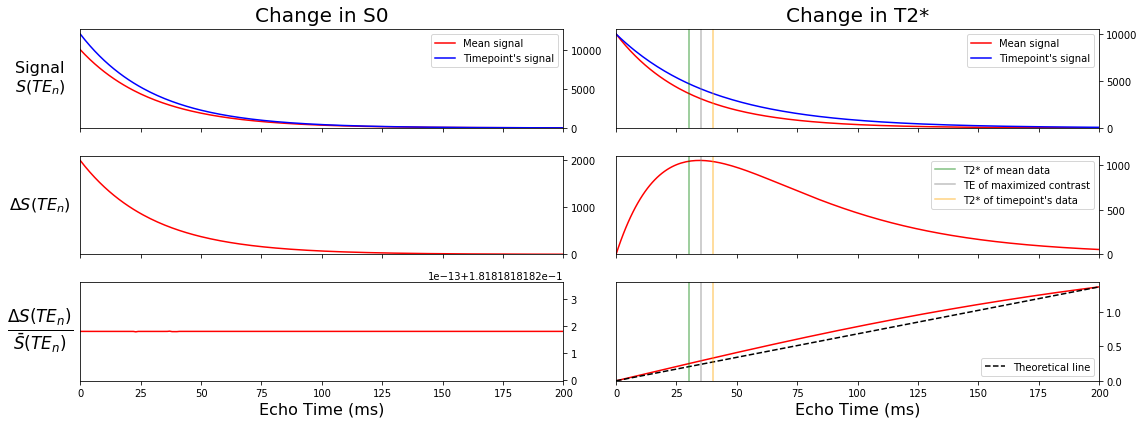

In [4]:
# change s0
fig, axes = plt.subplots(3, 2, figsize=(16, 6))
axes[0, 0].yaxis.tick_right()
axes[0, 0].set_xticklabels([])
axes[0, 0].plot(echo_times, mean_sig, 'red', label='Mean signal')
axes[0, 0].plot(echo_times, sig2, 'blue', label="Timepoint's signal")
axes[0, 0].set_ylim(0)
axes[0, 0].set_xlim(0, np.max(echo_times))
axes[0, 0].set_title('Change in S0', fontsize=20, y=1.02)
axes[0, 0].set_ylabel('Signal\n$S(TE_n)$',
                      fontsize=16, rotation=0, labelpad=40, va='center')
leg = axes[0, 0].legend()

axes[1, 0].yaxis.tick_right()
axes[1, 0].set_xticklabels([])
axes[1, 0].plot(echo_times, d_sig2, 'red')
axes[1, 0].set_ylim(0)
axes[1, 0].set_xlim(0, np.max(echo_times))
axes[1, 0].set_ylabel('${\\Delta}S(TE_n)$',
                      fontsize=16, rotation=0, labelpad=40, va='center')

# No slope, intercept at delta(S0)/mean(S0)
axes[2, 0].yaxis.tick_right()
axes[2, 0].plot(echo_times, dt_sig2, 'red')
axes[2, 0].set_xlim(0, np.max(echo_times))
axes[2, 0].set_ylabel('$\\frac{{\\Delta}S(TE_n)}{\\bar{S}(TE_n)}$',
                      fontsize=24, rotation=0, labelpad=40, va='center')
axes[2, 0].set_xlabel('Echo Time (ms)', fontsize=16)

# change t2s
# max diff is between orig and new T2*, but is definitely not mean
max_diff_te = echo_times[d_sig3 == np.max(d_sig3)][0]

axes[0, 1].yaxis.tick_right()
axes[0, 1].set_xticklabels([])
axes[0, 1].plot(echo_times, mean_sig, 'red', label='Mean signal')
axes[0, 1].plot(echo_times, sig3, 'blue', label="Timepoint's signal")
axes[0, 1].set_ylim(0)
axes[0, 1].set_xlim(0, np.max(echo_times))
axes[0, 1].set_title('Change in T2*', fontsize=20, y=1.02)

# Plot important echo times
axes[0, 1].axvline(mean_t2s, color='green', alpha=0.5)
axes[0, 1].axvline(max_diff_te, color='gray', alpha=0.5)
axes[0, 1].axvline(t2s2, color='orange', alpha=0.5)
leg = axes[0, 1].legend()

axes[1, 1].yaxis.tick_right()
axes[1, 1].set_xticklabels([])
axes[1, 1].plot(echo_times, d_sig3, 'red')
axes[1, 1].set_ylim(0)
axes[1, 1].set_xlim(0, np.max(echo_times))

# Plot important echo times
axes[1, 1].axvline(mean_t2s, label='T2* of mean data', color='green', alpha=0.5)
axes[1, 1].axvline(max_diff_te, label='TE of maximized contrast', color='gray', alpha=0.5)
axes[1, 1].axvline(t2s2, label="T2* of timepoint's data", color='orange', alpha=0.5)
leg = axes[1, 1].legend()

pred_slope = (dt_sig3[-1] - dt_sig3[0]) / (echo_times[-1] - echo_times[0])
pred_int = (pred_slope * echo_times[-1]) - dt_sig3[-1]
pred_max = pred_slope * echo_times[-1]

axes[2, 1].yaxis.tick_right()
axes[2, 1].plot(echo_times, dt_sig3, 'red')
axes[2, 1].plot([0, echo_times[-1]], [pred_int, pred_max],
                'black', linestyle='--', label='Theoretical line')
axes[2, 1].set_ylim(0)
axes[2, 1].set_xlim(0, np.max(echo_times))
axes[2, 1].set_xlabel('Echo Time (ms)', fontsize=16)
axes[2, 1].axvline(max_diff_te, color='gray', alpha=0.5)
axes[2, 1].axvline(mean_t2s, color='green', alpha=0.5)
axes[2, 1].axvline(t2s2, color='orange', alpha=0.5)
leg = axes[2, 1].legend()

fig.tight_layout()
#fig.show()
fig.savefig('simulated_fluctuations.png', dpi=400)

## Make design matrices

For TEDPCA and TEDICA, we use regression to get parameter estimates (PEs; not beta values) for component time-series against echo-specific data, and substitute those PEs for ${\bar{S}(TE_k)}$. At some point, I would like to dig into why those parameter estimates are equivalent to ${\bar{S}(TE_k)}$ for our purposes.

### TE-independence model
$$\frac{{\Delta}S(TE_k)}{\bar{S(TE_k)}} = \frac{{\Delta}S_0}{S_0}$$
$${\Delta}S(TE_k) = {\bar{S}(TE_k)}\frac{{\Delta}S_0}{S_0}$$

$\frac{{\Delta}S_0}{S_0}$ is a scalar (i.e., doesn't change with TE), so we ignore that, which means we only use ${\bar{S}(TE_k)}$ (mean echo-wise signal).

Thus,

$${\Delta}S(TE_k) = {\bar{S}(TE_k)} * X$$

and for TEDPCA/TEDICA,

$$PE(TE_k) = {\bar{S}(TE_k)} * X$$

Lastly, we fit X to the data and evaluate model fit.

### TE-dependence model
$$\frac{{\Delta}S(TE_k)}{\bar{S}(TE_k)} = -{\Delta}{R_2^*}*TE_k$$

$${\Delta}S(TE_k) = {\bar{S}(TE_k)} * -{\Delta}{R_2^*}*TE_k$$

$-{\Delta}{R_2^*}$ is a scalar, so we ignore it, which means we only use ${\bar{S}(TE_k)}$ (mean echo-wise-signal) and $TE_k$ (echo time in milliseconds).

Thus,

$${\Delta}S(TE_k) = {\bar{S}(TE_k)}*TE_k * X$$

and for TEDPCA/TEDICA,

$$PE(TE_k) = {\bar{S}(TE_k)}*TE_k * X$$

Lastly, we fit X to the data and evaluate model fit.

In [5]:
X1 = (mean_sig)[:, None]  # Model 1

# NOTE: T2* is unnecessary for this, since it's a scalar
X2 = ((echo_times * mean_sig) / mean_t2s)[:, None]  # Model 2

n_echos = len(echo_times)

## Fitted curves for S0-perturbed signal
The predicted curve for the S0 model matches the real curve perfectly!

In [6]:
B = d_sig2[:, None]  # (E x S)
alpha = (np.abs(B)**2).sum(axis=0)

# S0 Model
coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
pred_S0 = X1 * np.tile(coeffs_S0, (n_echos, 1))
SSE_S0 = (B - pred_S0)**2
SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)
pred_S0_2 = pred_S0.copy()

# R2 Model
coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
pred_R2 = X2 * np.tile(coeffs_R2, (n_echos, 1))
SSE_R2 = (B - pred_R2)**2
SSE_R2 = SSE_R2.sum(axis=0)
F_R2 = (alpha - SSE_R2) * (n_echos - 1) / (SSE_R2)
pred_R2_2 = pred_R2.copy()

print('Rho: {}'.format(F_S0[0]))
print('Kappa: {}'.format(F_R2[0]))
print()

# Parameter estimate * mean S0 gives delta(S0)
print('Real delta S0: {}'.format(s02 - mean_s0))
print('Delta S0 from results: {}'.format(coeffs_S0[0] * mean_s0))

Rho: 1.0077632508933493e+32
Kappa: 187.14447409804944

Real delta S0: 2000
Delta S0 from results: 1999.9999999999811


## Fitted curves for R2*-perturbed signal
For some reason, the predicted curve for the R2 model doesn't match the real signal curve. What's with this mismatch?

It seems like the mismatch increases as the difference between the fluctuating volume's R2 and the mean R2 increase. The fitted curve seems to actually match the mean signal, not the perturbed signal!

In [7]:
B = d_sig3[:, None]  # (E x S)
alpha = (np.abs(B)**2).sum(axis=0)

# S0 Model
coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
pred_S0 = X1 * np.tile(coeffs_S0, (n_echos, 1))
SSE_S0 = (B - pred_S0)**2
SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)
pred_S0_3 = pred_S0.copy()

# R2 Model
coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
pred_R2 = X2 * np.tile(coeffs_R2, (n_echos, 1))
SSE_R2 = (B - pred_R2)**2
SSE_R2 = SSE_R2.sum(axis=0)
F_R2 = (alpha - SSE_R2) * (n_echos - 1) / (SSE_R2)
pred_R2_3 = pred_R2.copy()

print('Rho: {}'.format(F_S0[0]))
print('Kappa: {}'.format(F_R2[0]))

Rho: 141.6734530583628
Kappa: 12491.108984702205


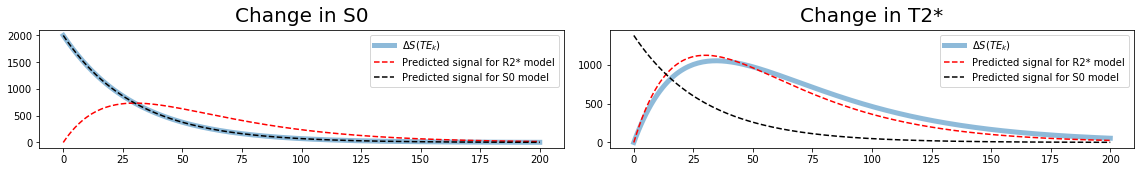

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 2.5))

axes[0].set_title('Change in S0', fontsize=20, y=1.02)
axes[0].plot(echo_times, d_sig2, label='${\Delta}S(TE_k)$',
             linewidth=5, alpha=0.5)
axes[0].plot(echo_times, np.squeeze(pred_R2_2),
             label='Predicted signal for R2* model',
             linestyle='--', color='red')
axes[0].plot(echo_times, np.squeeze(pred_S0_2),
             label='Predicted signal for S0 model',
             linestyle='--', color='black')
legend = axes[0].legend()

axes[1].set_title('Change in T2*', fontsize=20, y=1.02)
axes[1].plot(echo_times, d_sig3, label='${\Delta}S(TE_k)$',
             linewidth=5, alpha=0.5)
axes[1].plot(echo_times, np.squeeze(pred_R2_3),
             label='Predicted signal for R2* model',
             linestyle='--', color='red')
axes[1].plot(echo_times, np.squeeze(pred_S0_3),
             label='Predicted signal for S0 model',
             linestyle='--', color='black')
legend = axes[1].legend()

fig.tight_layout()
fig.savefig('model_fits.png', dpi=400)

In [9]:
# lstsq gives same result as model fit method by kundu, which is great to see
x, res, rank, sing = np.linalg.lstsq(X2, B, rcond=None)
print(x[0])
print(coeffs_R2)

[0.30605658]
[0.30605658]


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


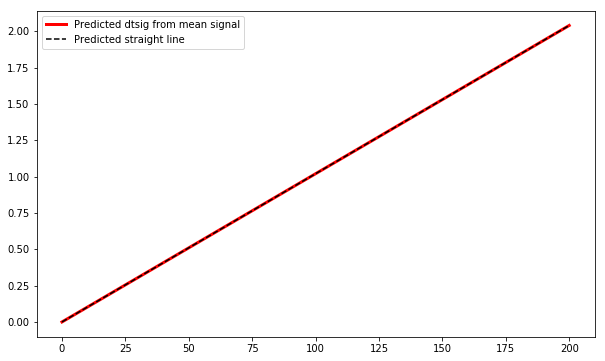

In [10]:
# The predicted signal seems to be equivalent to the
# _mean_ signal, not the R2*-fluctuating signal
pred_dtsig = np.squeeze(pred_R2) / mean_sig
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(echo_times, pred_dtsig, 'red', linewidth=3,
        label='Predicted dtsig from mean signal')

pred_slope = (pred_dtsig[-1] - pred_dtsig[0]) / (echo_times[-1] - echo_times[0])
pred_int = (pred_slope * echo_times[-1]) - pred_dtsig[-1]
pred_max = pred_slope * echo_times[-1]
ax.plot([0, echo_times[-1]], [pred_int, pred_max], 'black',
        linestyle='--', label='Predicted straight line')
leg = ax.legend()
fig.show()